<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp1_rank%2Bfeature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

In [41]:
class TwoLayerNN(nn.Module):
  def __init__(self, m, d): # fix the second layer to be all 1
    super().__init__()
    self.fc1 = nn.Linear(d, m, bias=False)
    self.fc2 = nn.Linear(m, 1, bias=False)

  def activation(self, x): # cubic relu activation
    return (x.clamp(min=0))

  def forward(self, x):
    _output = self.activation(self.fc1(x))
    output = self.fc2(_output)
    return output

  def features(self, x, normalize=True, scaled=False, n_hidden_to_take=-1):
    for i in range(n_hidden_to_take if n_hidden_to_take > 0 else 1):
      x = F.relu(self.fc1(x))
    if scaled and n_hidden_to_take in [-1, 3]:
      x = self.fc2(x)
    if normalize:
      x /= (x**2).sum(1, keepdim=True)**0.5
      x[torch.isnan(x)] = 0.0
    return x.data.numpy()

  def feature_sparsity(self, X, n_hidden_to_take=-1, corr_threshold=0.99):
    phi = self.features(X, n_hidden_to_take=n_hidden_to_take)
    idx_keep = np.where((phi > 0.0).sum(0) > 0)[0]
    phi_filtered = phi[:, idx_keep]  # filter out zeros
    corr_matrix = np.corrcoef(phi_filtered.T)
    corr_matrix -= np.eye(corr_matrix.shape[0])

    idx_to_delete, i, j = [], 0, 0
    while i != corr_matrix.shape[0]:
      # print(i, corr_matrix.shape, (np.abs(corr_matrix[i]) > corr_threshold).sum())
      if (np.abs(corr_matrix[i]) > corr_threshold).sum() > 0:
        corr_matrix = np.delete(corr_matrix, (i), axis=0)
        corr_matrix = np.delete(corr_matrix, (i), axis=1)
        # print('delete', j)
        idx_to_delete.append(j)
      else:
        i += 1
      j += 1
    assert corr_matrix.shape[0] == corr_matrix.shape[1]
    # print(idx_to_delete, idx_keep)
    idx_keep = np.delete(idx_keep, [idx_to_delete])
    sparsity = (phi[:, idx_keep] != 0).sum() / (phi.shape[0] * phi.shape[1])

    return sparsity

In [42]:
n = 70
D_in = 2
D_out = 1
m = 20
l0_threshold_grad_matrix = 0.0001

def get_data(n, D_in):
  x=torch.randn(n,D_in)
  torch.nn.init.normal_(x, 0, 1) # initialize x

  u=torch.rand(D_in,D_out)
  u=u/u.norm() # ||u||=1
  y=x.mm(u)
  y=y.clamp(min=0)

  return x, y

In [43]:
x, y = get_data(n, D_in)
model =  TwoLayerNN(m, D_in)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=0)
criteria = nn.MSELoss()

In [44]:
def weights_init(m):
  for p in m.parameters():
    nn.init.xavier_uniform_(p, gain=.1)

# def train(epochs, lr):
#   model =  TwoLayerNN(m, D_in)
#   model.apply(weights_init)
#   optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

#   model.train()
#   res = []
#   for epoch in range(epochs):
#     output = model(x)
#     loss = criteria(output, y)

#     optimizer.zero_grad()
#     loss.backward()

#     optimizer.step()

#     tmp = []
#     flag = 0
#     for p in model.parameters():
#       print(np.linalg.matrix_rank(p.data.numpy()))
#       tmp += np.linalg.matrix_rank(p.data.numpy())
#       break;
#       # tmp += [(p.clone().detach()**2).sum(dim=-1).numpy()]

#     res += [tmp]
#     if epoch % 100 == 0:
#       print (epoch, loss.item())

#   return np.array(res)
def train(epochs, lr):
  train_loss, nets_avg = [], []
  model = TwoLayerNN(m, D_in)
  model.apply(weights_init)
  net, net_avg = copy.deepcopy(model), copy.deepcopy(model)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0, weight_decay=0)
  net.train()

  for epoch in range(epochs):
    output = net(x)
    loss = criteria(output, y)
    if epoch % 100 == 0:
      print (epoch, loss.item())
    train_loss += [loss.item()]
    nets_avg.append(copy.deepcopy(net))

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return train_loss, nets_avg

In [45]:
def compute_grad_matrix(net, X):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0)
    grad_matrix_list = []
    for i in range(X.shape[0]):
        h = net(X[[i]])
        optimizer.zero_grad()
        h.backward()

        grad_total_list = []
        for param in net.parameters():
            grad_total_list.append(param.grad.flatten().data.numpy())

        grad_total = np.concatenate(grad_total_list)
        grad_matrix_list.append(grad_total)

    grad_matrix = np.vstack(grad_matrix_list)
    return grad_matrix

def compute_grad_matrix_ranks(nets, X, l0_threshold_grad_matrix=0.0001):
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X[:n_params]
    grad_matrix_ranks = []
    for net in nets:
        svals = np.linalg.svd(compute_grad_matrix(net, X_eval))[1]
        rank = (svals / svals[0] > l0_threshold_grad_matrix).sum()
        grad_matrix_ranks.append(rank)
    return grad_matrix_ranks

In [46]:
lr_small = 0.005
loss_small, net_small = train(15000, lr=lr_small)

0 0.4245467185974121
100 0.41302618384361267
200 0.3990050256252289
300 0.3740261197090149
400 0.32642045617103577
500 0.24686382710933685
600 0.14623941481113434
700 0.06266965717077255
800 0.019688865169882774
900 0.005064006894826889
1000 0.00126271799672395
1100 0.00038602063432335854
1200 0.00018258752243127674
1300 0.00012863772280979902
1400 0.00011016855569323525
1500 0.00010186637518927455
1600 9.757798397913575e-05
1700 9.443108137929812e-05
1800 9.180612687487155e-05
1900 8.945316221797839e-05
2000 8.726904343347996e-05
2100 8.519547554897144e-05
2200 8.320393681060523e-05
2300 8.126763714244589e-05
2400 7.938749331515282e-05
2500 7.755823025945574e-05
2600 7.596168870804831e-05
2700 7.44058852433227e-05
2800 7.291187648661435e-05
2900 7.154971535783261e-05
3000 7.022225327091292e-05
3100 6.892708188388497e-05
3200 6.766259321011603e-05
3300 6.643703090958297e-05
3400 6.531034159706905e-05
3500 6.420773570425808e-05
3600 6.313029007287696e-05
3700 6.210762512637302e-05
3800 

In [48]:
lr_large = 0.3
loss_large, net_large = train(15000, lr=lr_large)

0 0.41687247157096863
100 1.3093123016005848e-05
200 6.972048140596598e-06
300 3.988227945228573e-06
400 2.54437213698111e-06
500 1.7071512274924316e-06
600 1.347304987575626e-06
700 1.0877433851419482e-06
800 8.89528621428326e-07
900 7.196709930212819e-07
1000 5.829986662320152e-07
1100 4.7355112542391e-07
1200 3.86121968176667e-07
1300 3.1607689265911176e-07
1400 2.5985718821175396e-07
1500 2.1511945647034736e-07
1600 1.7869071200493636e-07
1700 1.4900693656727526e-07
1800 1.2495657131239568e-07
1900 1.0528777494300812e-07
2000 8.914464189047067e-08
2100 7.588582207063155e-08
2200 6.497573679098423e-08
2300 5.59754163020898e-08
2400 4.854086199657104e-08
2500 4.2392645838162935e-08
2600 3.72982249530196e-08
2700 3.3068058513663345e-08
2800 2.9885629970749505e-08
2900 2.7533529234347043e-08
3000 2.5484025556465895e-08
3100 2.369224993969965e-08
3200 2.212011374069789e-08
3300 2.0732978001092306e-08
3400 1.950640893255695e-08
3500 1.8414468172522902e-08
3600 1.7441077915236747e-08
3700

In [ ]:
print(net_small[1])
for param in net_small[-1].parameters():
  print(param)
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
print(n_params)
print(x[:n_params].size())

TwoLayerNN(
  (fc1): Linear(in_features=2, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=1, bias=False)
)
Parameter containing:
tensor([[-6.2956e-03,  2.0814e-03],
        [-1.4530e-02,  1.2575e-02],
        [ 5.9332e-02, -2.8264e-02],
        [ 1.1212e-01,  1.1603e-01],
        [ 3.8775e-01,  2.7301e-01],
        [-1.4203e-02, -3.7759e-02],
        [-3.8438e-02, -3.0234e-02],
        [-2.1376e-02,  3.1010e-02],
        [ 1.8125e-01,  9.2113e-02],
        [ 2.4705e-01,  1.3929e-01],
        [ 3.9745e-01,  2.5380e-01],
        [-4.5415e-02,  3.8050e-02],
        [ 3.3281e-01,  2.2650e-01],
        [ 3.0793e-01,  2.3614e-01],
        [-1.1424e-02, -3.0058e-02],
        [ 2.2671e-03, -2.3054e-02],
        [ 2.5965e-01,  1.6530e-01],
        [ 2.5029e-03, -8.9435e-03],
        [-5.0754e-02,  2.3156e-02],
        [ 2.5367e-04,  7.2532e-02]], requires_grad=True)
Parameter containing:
tensor([[-0.0140, -0.0272,  0.0360,  0.1588,  0.4710, -0.0294,  0.0142,  0.0237,


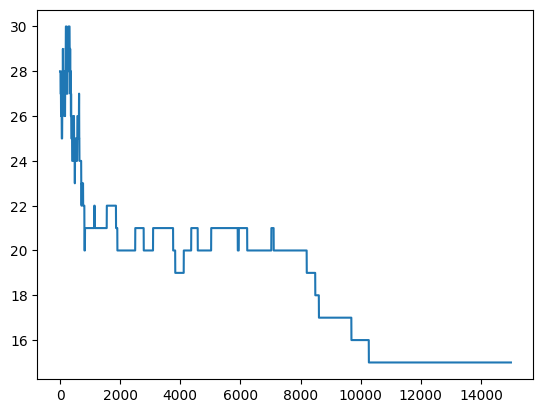

In [50]:
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_small, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)
# for i in range(m):
#   plt.xlim(0, 400)
#   plt.ylim(0, 0.15)
#   plt.plot(norm_small[::10, 0, i])
#   plt.title('lr={0}'.format(lr_small))
  #plt.plot(log2[::10, 1, i])

TwoLayerNN(
  (fc1): Linear(in_features=2, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=1, bias=False)
)


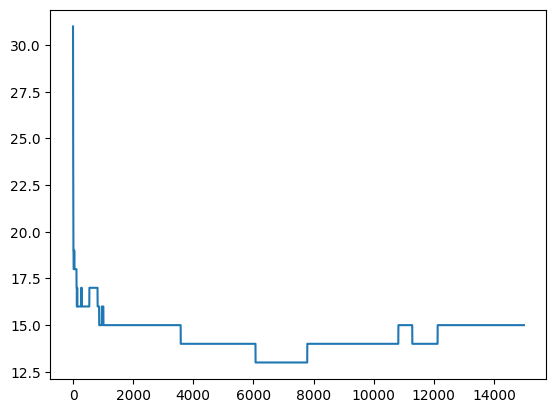

In [51]:
print(net_large[1])
n_params = sum([np.prod(param.shape) for param in net_large[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_large, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)

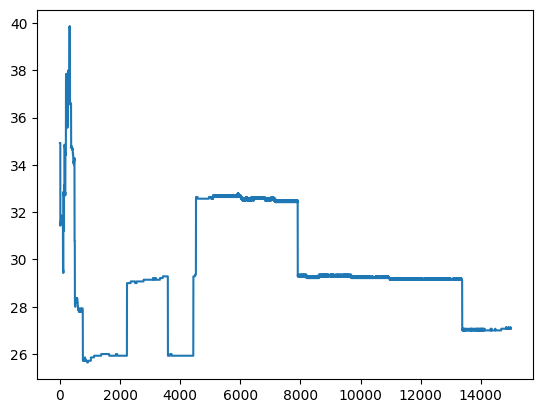

In [47]:
feature_sparsity_small = np.array([net.feature_sparsity(x) for net in net_small])
plt.plot(100*feature_sparsity_small)

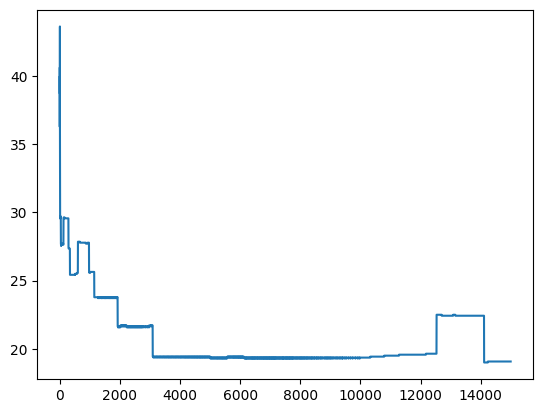

In [49]:
feature_sparsity_large = np.array([net.feature_sparsity(x) for net in net_large])
plt.plot(100*feature_sparsity_large)

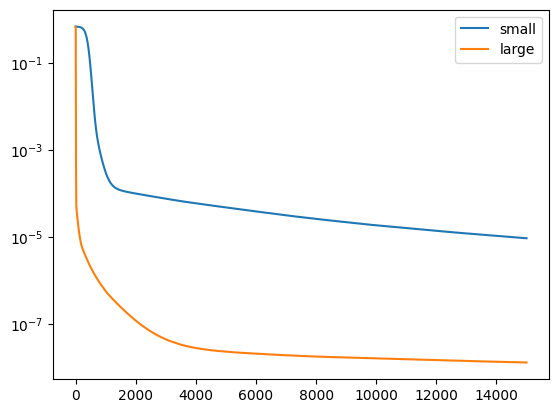

In [ ]:
fig,ax = plt.subplots()
plt.yscale('log')
plt.plot(loss_small, label='small')
plt.plot(loss_large, label='large')
ax.legend()